In [2]:
import os
os.environ['CONFIG'] = 'char_anom'
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Optional, Tuple
from functools import partial
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorly as tl
tl.set_backend('numpy')
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from tfm.models.pca import RPPCA
from tfm.tl_parafac_fix_intercept import parafac_fix_intercept
from tfm.utils import *

### load data

In [3]:
# Read tensor data
X = jnp.load(f'{dir_input}/{os.environ['CONFIG']}/mat_ptf_re_lag_{max_lag}.npz')['mat_ptf_re_rank']

# Read the dictionary parameters
params = jnp.load(f'{dir_input}/{os.environ['CONFIG']}/dict_param_lag_{max_lag}.pkl', allow_pickle=True)

assert params['max_lag'] == max_lag
bin_labels, _, _, max_lag, frac_longshort, all_dates, start_date_maxlag = params.values()
T = len(all_dates)
start_date = all_dates[0]
dates_fit = all_dates[all_dates < start_date_oos]
dates_oos = all_dates[all_dates >= start_date_oos]
T_fit = len(dates_fit)
T_oos = len(dates_oos)

# Read FF market factor
df_ff = jnp.load(f'{dir_input}/df_FF_factors.pkl', allow_pickle=True) * 0.01 
df_ff = df_ff.loc[all_dates]

# Get excess returns ie. excess to normal factor
if input_type == 'rx':
    X = X - X[:, 0, :][:, jnp.newaxis, :]
if normalize_ret:
    X = X / X.std(axis=0, keepdims=True) * df_ff['Mkt-RF'].std()

num_ptf = X.shape[2]
assert not jnp.isnan(X).any()
# X_log = jnp.log(1 + X)

NameError: name 'dir_input' is not defined

In [3]:
print(f'start_date_maxlag: {start_date_maxlag}')
print(f'start_date: {start_date}')
print(f'Shape of X: {X.shape}, (Months, Lags, Factor)')
print(f'OOS period: {dates_oos[0]} to {dates_oos[-1]}')
print(f'T_fit: {T_fit}; T_oos: {T_oos}')

# Output directory
dir_out = f'../results_oos/{os.environ['CONFIG']}/fig_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'
dir_out_table = f'../results_oos/{os.environ['CONFIG']}/tbl_onefit_oos_{input_type}_{spec}_ver{idx_ver}/'

if not os.path.exists(dir_out):
    os.makedirs(dir_out)
if not os.path.exists(dir_out_table):
    os.makedirs(dir_out_table)

start_date_maxlag: 1972-07-01 00:00:00
start_date: 1977-06-01 00:00:00
Shape of X: (519, 60, 43), (Months, Lags, Factor)
OOS period: 2000-01-01 00:00:00 to 2020-08-01 00:00:00
T_fit: 271; T_oos: 248


In [4]:
# OOS settings
lst_K = [1, 3, 5, 10, 20, 30, 40]

### utils

In [5]:
def RPPCA_one_window(X_fit, X_oos, lst_K, gamma=-1):
    T_fit, N = X_fit.shape
    T_oos = X_oos.shape[0]

    # Allocating space like this is slow - maybe append to a list and then concatenate?
    # mat_ret_mv_oos = jnp.full((T_oos, len(lst_K)), jnp.nan) # OOS ret or rx 
    # mat_X_oos_fitted = jnp.full((T_oos, len(lst_K), N), jnp.nan)
    mat_ret_mv_oos = jnp.zeros((T_oos, len(lst_K))) # OOS ret or rx 
    mat_X_oos_fitted = jnp.zeros((T_oos, len(lst_K), N))
    
    Fhat, Lambdahat = [jnp.real(Q) for Q in RPPCA(X=X_fit, K=max(lst_K), gamma=gamma)]

    pbar = tqdm(total=len(lst_K))
    for idx_K, K in enumerate(lst_K):

        ### get MV ptf oos return - could write this into a helper function, not jit'ed
        if K > 1:
            SDFweights = jnp.linalg.inv(jnp.cov(Fhat[:, :K].T)) @ jnp.mean(Fhat[:, :K], axis=0).T
        else:  
            SDFweights = jnp.mean(Fhat[:, :K]) / jnp.var(Fhat[:, :K])
            SDFweights = jnp.array([SDFweights])
        # Can move below logic into helper function - args are lambdahat[:, :K], SDFweights, X_oos
        # Returns slice of mat_ret_mv_oos and mat_X_oos_fitted
        SDFweightsassets_k = Lambdahat[:, :K] @ SDFweights # dim: (N,)

        # Get oos ret
        ret_oos = X_oos @ SDFweightsassets_k
        mat_ret_mv_oos = mat_ret_mv_oos.at[:, idx_K].set(ret_oos)
        
        ### get fit of X_oos
        F_oos_fitted = X_oos @ Lambdahat[:, :K]
        X_oos_fitted = F_oos_fitted @ Lambdahat[:, :K].T
        mat_X_oos_fitted = mat_X_oos_fitted.at[:, idx_K, :].set(X_oos_fitted)
        pbar.update(1)
        
    sr_oos = mat_ret_mv_oos.mean(axis=0) / mat_ret_mv_oos.std(axis=0)
    dict_out = {
        'mat_X_fitted_oos': mat_X_oos_fitted, # dim: (T_oos, len(lst_K), N) - multi-horizon return predictions for all factors, times
        'mat_ret_mv_oos': mat_ret_mv_oos, # dim: (T_oos, len(lst_K)) - oos returns computed using is sdf weights
        'sr_oos': sr_oos, # dim: (len(lst_K)) - oos sharpe ratio
    }
    return dict_out


### procedure: pca

- takes 13s to run the below block when `RPPCA` is `jax.jit`-ed vs. 92s in original notebook without it
- used `jnp.linalg.eigh` for finding eigenvalues/vectors of cov matrix bc hermitian
- hard to optimize further b/c in RPPCA, we need to select $K$ eigenvectors ==> we need to index, which forces $K$ to be static and thus we can't VMAP over it

In [6]:
##############
## PCA
##############
dict_fit_oos = defaultdict(dict)

X_flatten = X[:, :max_lag, :].reshape(X.shape[0], -1)
X_onelag_pca = X[:, 1, :] if fit_rx else X[:, 0, :] # False in this nb

dict_fit_pca_onelag = RPPCA_one_window(
    X_onelag_pca[:T_fit], X_onelag_pca[T_fit:], lst_K, gamma=-1
)

dict_fit_pca = RPPCA_one_window(
    X_flatten[:T_fit], X_flatten[T_fit:], lst_K, gamma=-1
)

for idx_K, K in enumerate(lst_K):
    dict_fit_oos['PCA'][K] = {
        'ret_mv_oos': dict_fit_pca['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca['mat_X_fitted_oos'][:, idx_K, :].reshape(T_oos, max_lag, num_ptf),
        'sr_oos': dict_fit_pca['sr_oos'][idx_K]
    }
    
    dict_fit_oos['PCA One Lag'][K] = {
        'ret_mv_oos': dict_fit_pca_onelag['mat_ret_mv_oos'][:, idx_K],
        'X_fitted_oos': dict_fit_pca_onelag['mat_X_fitted_oos'][:, idx_K, :],
        'sr_oos':dict_fit_pca_onelag['sr_oos'][idx_K]
    }

100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


### procedure: tensor

- original code takes 10m to run, can't `jax.jit` the parafac function, too much conditional logic and not traceable
- numpy backend 2x faster than jax backend?
    - tensorly implementation for most functions appears to be in numpy, if we pass them in as jax tensors, this slows to down? (inherent difference bc jax arrays immutable vs numpy arrays are not)

clean this code up into functions, add to `_tensor.py` and `utils.py`

In [7]:
##############
## Tensor
##############

def Tensor_One_Window(X_fit, X_oos, lst_K):
    """
    
    """
    res = {}

    pbar = tqdm(total=len(lst_K))
    for idx_K, K in enumerate(lst_K):
        print('Tensor: Processing K={} ...'.format(K))
        decomp = parafac_fix_intercept(
            tensor=X_fit,
            rank=K, 
            verbose=False,
            random_state=np.random.RandomState(random_seed),
            return_errors=False,
            n_iter_max=n_iter_max
        )
        dict_fit = dict(zip(['F','W','B'], decomp.factors))
        dict_fit['S'] = decomp.weights
        dict_fit = get_normalized_factors(dict_fit, reorder=True)

        # get F_next by regress X_next - allocating space like this is pretty slow
        F_oos = np.zeros((T_oos, K))
        
        for idx_t in range(T_oos):
            X_oos_flatten = X_oos[idx_t].reshape(1, -1)
            Z_fit = np.zeros((K,num_ptf * max_lag))
            for i in range(K):
                Z_fit[i] = np.kron(dict_fit['W'][:, i], dict_fit['B'][:, i]) * dict_fit['S'][i]
            mat_weight_flatten = Z_fit.T @ np.linalg.inv(Z_fit @ Z_fit.T) # dim: (num_char*max_lag, K+1)
            F_oos[idx_t] = X_oos_flatten @ mat_weight_flatten

        # mean-var portfolio construction. get scaler return (rx)
        # mat_ret_mv_oos, dim: (T_oos)
        if K > 1:
            ret_mv_oos = F_oos @ np.linalg.inv(np.cov(dict_fit['F'].T)) @ dict_fit['F'].mean(axis=0)
        else:
            ret_mv_oos = F_oos * np.mean(dict_fit['F']) / np.var(dict_fit['F'])

        sr_oos = ret_mv_oos.mean(axis=0) / ret_mv_oos.std(axis=0)

        # get fit of next period return. expected_re is of dim (T_oos, num_ptf, max_lag)
        X_fitted_oos = np.zeros((T_oos, max_lag, num_ptf))

        for i in range(0, K):
            BWS = (dict_fit['W'][:, i][:, np.newaxis] @ dict_fit['B'][:, i][:, np.newaxis].T) * dict_fit['S'][i]
            X_fitted_oos += F_oos[:, i][:, np.newaxis, np.newaxis] * BWS

        res[K] = {
            'ret_mv_oos': ret_mv_oos, # dim: (T_oos,)
            'X_fitted_oos': X_fitted_oos, # dim: (T_oos, max_lag, num_ptf)  
            'sr_oos': sr_oos
        }
        
        pbar.update(1)
    
    return res 

In [8]:
dict_fit_oos['Tensor'] = Tensor_One_Window(np.asarray(X[:T_fit]), np.asarray(X[T_fit:]), lst_K)

  0%|          | 0/7 [00:00<?, ?it/s]

Tensor: Processing K=1 ...
Tensor: Processing K=3 ...


 29%|██▊       | 2/7 [00:02<00:05,  1.09s/it]

Tensor: Processing K=5 ...


 43%|████▎     | 3/7 [00:04<00:07,  1.79s/it]

Tensor: Processing K=10 ...


 57%|█████▋    | 4/7 [00:10<00:09,  3.10s/it]

Tensor: Processing K=20 ...


 71%|███████▏  | 5/7 [00:21<00:11,  5.85s/it]

Tensor: Processing K=30 ...


 86%|████████▌ | 6/7 [00:38<00:09,  9.48s/it]

Tensor: Processing K=40 ...


100%|██████████| 7/7 [00:59<00:00,  8.54s/it]


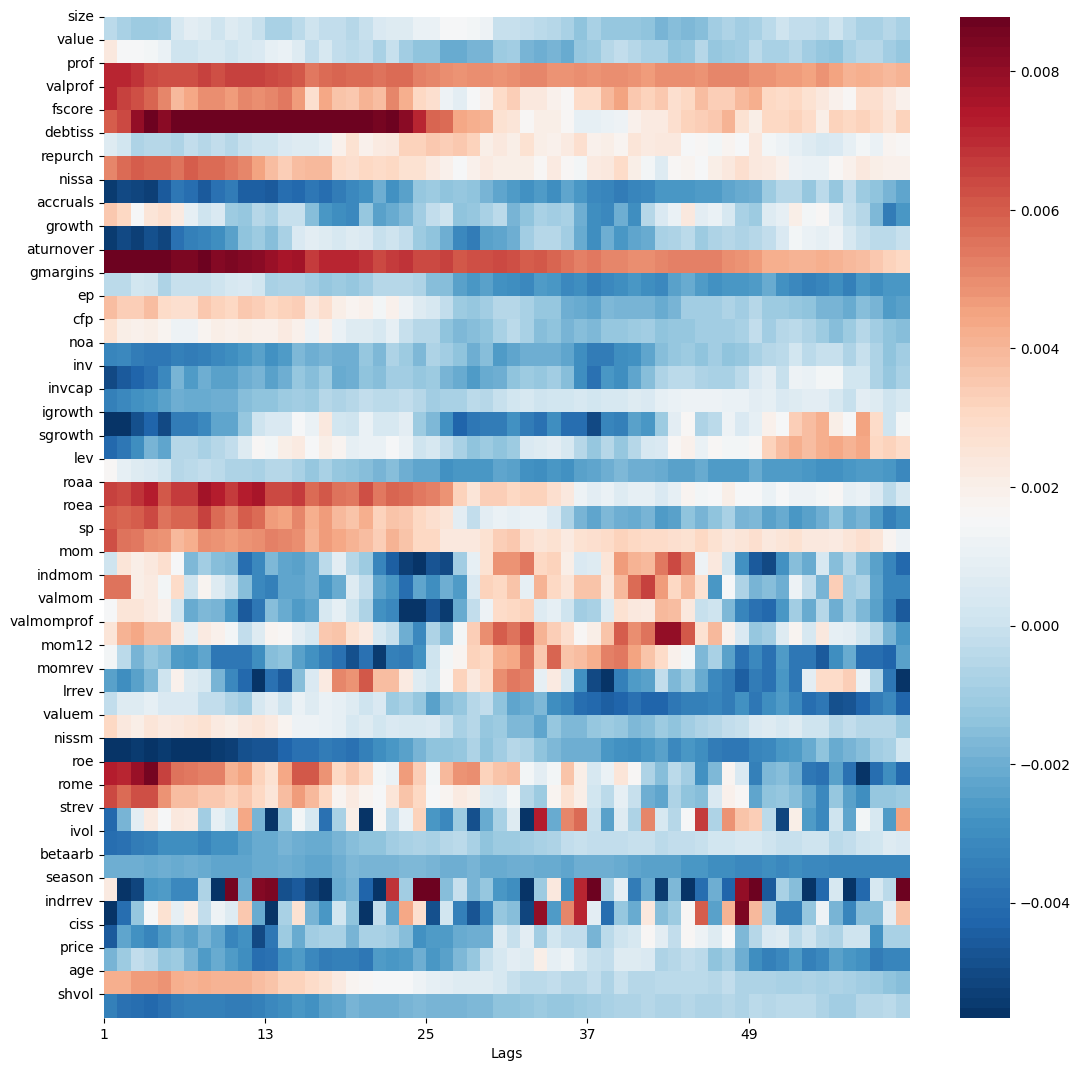

In [101]:
### plot mean return and fitted mean return
X_mean = X[T_fit:].mean(axis=0)
q_ylim = 0.01
ylim_mean = [np.quantile(X_mean, q_ylim), np.quantile(X_mean, 1 - q_ylim)]
# mean oos return
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(1,1,1)    
sns.heatmap(
    X_mean.T, annot=False, fmt='.0e', ax=ax, cmap=sns.color_palette("RdBu_r", n_colors=100),
    vmin=ylim_mean[0], vmax=ylim_mean[1]
);
ax.set_yticks(np.arange(len(bin_labels)))
ax.set_yticklabels(bin_labels, rotation=0);
ax.set_xticks(np.arange(0, max_lag, 12))
ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
ax.set_xlabel('Lags');
filename='term_structure_mean_ret.pdf'
fig.savefig(dir_out+filename, bbox_inches='tight')

In [10]:
# mean fitted oos return
for method in ['Tensor', 'PCA']:
    for idx_K, K in enumerate(lst_K):
        # get fitted expected return
        X_fit_oos=dict_fit_oos[method][K]['X_fitted_oos']
        expected_re_fit=X_fit_oos.mean(axis=0)

        # plot
        fig=plt.figure(figsize=(13,13))
        ax=fig.add_subplot(1,1,1)    
        sns.heatmap(expected_re_fit.T,
                    annot=False,
                    fmt='.0e',
                    ax=ax,
                    cmap=sns.color_palette("RdBu_r", n_colors=100),
                    vmin=ylim_mean[0], vmax=ylim_mean[1]
        );
        ax.set_yticks(np.arange(len(bin_labels)))
        ax.set_yticklabels(bin_labels, rotation=0);
        ax.set_xticks(np.arange(0,max_lag,12))
        ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
        ax.set_xlabel('Lags');

        filename='term_structure_{}_fitted_ret_K{}.pdf'\
            .format(method, K)
        #print(filename)
        fig.savefig(dir_out+filename, bbox_inches='tight')
        plt.close('all')



In [11]:
def calc_eval_metrics(X_in, X_rc):

    X_rc_1ex = X_rc[:,0,:]

    eps = X_in - X_rc # dim: (T, max_lag, num_ptf)
    eps_1ex = (X_in - X_in[:, 0, :][:,np.newaxis,:]) - (X_rc - X_rc_1ex[:,np.newaxis,:])

    ### metrics, not aggregated
    # pricing error
    alpha = eps.mean(axis=0) # dim: (max_lag, num_ptf)
    alpha_1ex = eps_1ex.mean(axis=0) # dim: (max_lag, num_ptf)

    # unexplained variance
    var_resid = (eps**2).mean(axis=0) - alpha**2 # dim: (max_lag, num_ptf)
    var_resid_1ex = (eps_1ex**2).mean(axis=0) - alpha_1ex**2 # dim: (max_lag, num_ptf)
    

    ### normalized averaged metrics
    # XS-alpha
    xs_alpha = np.sqrt((alpha**2).mean()) # scalar
    xs_alpha_1ex = np.sqrt((alpha_1ex**2).mean()) # scalar

    xs_alpha_ptf  = np.sqrt((alpha**2).mean(axis=0)) # dim: (num_ptf, )
    xs_alpha_ptf_1ex  = np.sqrt((alpha_1ex**2).mean(axis=0)) # dim: (num_ptf, )
    
    xs_alpha_lag  = np.sqrt((alpha**2).mean(axis=1)) # dim: (max_lag, )
    xs_alpha_lag_1ex  = np.sqrt((alpha_1ex**2).mean(axis=1)) # dim: (max_lag, )

    # unexplained var
    sigma_eps = np.sqrt(var_resid.mean()) \
        /np.sqrt(np.var(X_in, axis=0).mean()) # scalar
    sigma_eps_1ex = np.sqrt(var_resid_1ex.mean())\
        /np.sqrt(np.var(X_in - X_in[:,0,:][:,np.newaxis,:], axis=0).mean()) # scalar
    
    
    # fitting error decomposition into lag and cross components
    eps_cross=eps[:,0,:]
    eps_lag=eps-eps_cross[:,np.newaxis,:]

    eps_cross_rms=(eps_cross**2).mean(axis=0)**.5
    eps_lag_rms=(eps_lag**2).mean(axis=0)**.5
    
    
    # fitting rmse averaged over two dimensions
    dict_rmse={}
    lst_mean_axis=[(1,2),(0,2),(0,1)]
    lst_rmse_dim_name=['rmse_time', 'rmse_lag', 'rmse_portfolio']

    for mean_axis, dim_name in zip(lst_mean_axis,lst_rmse_dim_name):
        rmse_dim=np.sqrt(((X_in-X_rc)**2).mean(axis=mean_axis))
        dict_rmse[dim_name]=rmse_dim
    
    ### record results
    dict_eval = {
                 'alpha':alpha,
                'alpha_1ex':alpha_1ex,
                'var_resid':var_resid,
                'var_resid_1ex':var_resid_1ex,
                 
                'xs_alpha':xs_alpha,
                'xs_alpha_1ex':xs_alpha_1ex,
                'xs_alpha_ptf':xs_alpha_ptf,
                'xs_alpha_ptf_1ex':xs_alpha_ptf_1ex,
                 'xs_alpha_lag':xs_alpha_lag,
                 'xs_alpha_lag_1ex':xs_alpha_lag_1ex,
                 
                'sigma_eps':sigma_eps,
                'sigma_eps_1ex':sigma_eps_1ex,
                 'eps_cross_rms':eps_cross_rms,
                 'eps_lag_rms':eps_lag_rms
                }
    dict_eval.update(dict_rmse)
    
    return dict_eval

In [12]:
def print_matrix(A,row_title=None,col_title=None,print_multiplier=1, fmt='{:.3f}'):
    '''
    print(print_matrix(A))
    '''
    str_out=''
    (num_row,num_col)=A.shape
    
    if row_title is not None:
        assert len(row_title)==num_row
        
    if col_title is not None:
        for i,title in enumerate(col_title):
            if i==len(col_title)-1:
                str_out+=title+'\\\\'
            else:
                str_out+=title+'&'
        str_out+='\n'
        
    for i in range(0,num_row):
        str_temp=''
        if row_title is not None:
            str_temp+=row_title[i]+'&'
        for j in range(0,num_col):
            str_temp+=fmt.format(A[i,j]*print_multiplier)
            if j==num_col-1:
                str_temp+='\\\\'
            else:
                str_temp+='&'
        #str_temp=str_temp.replace('<','$<$').replace('>','$>$')
        str_out+=str_temp+'\n'
    return str_out

def get_plot_ylim(dict_eval_method, lst_K, key, q_lb=0.1):
    q_ub=1-q_lb
    
    ylim = [float('inf'), -float('inf')]
    for K in lst_K:
        ylim[0] = min(ylim[0], np.quantile(dict_eval_method[K]['eval'][key], q_lb))
        ylim[1] = max(ylim[1], np.quantile(dict_eval_method[K]['eval'][key], q_ub))
        
    return ylim
    
def collect_eval_metric(dict_eval_method, lst_K, key):
    temp = []
    for K in lst_K:
        temp.append(np.array(dict_eval_method[K]['eval'][key]))
    return np.stack(temp, axis=-1)

In [13]:
for method in ['Tensor', 'PCA']: 
    for idx_K, K in enumerate(lst_K):

        X_rc=dict_fit_oos[method][K]['X_fitted_oos']

        dict_eval_temp=calc_eval_metrics(X[T_fit:], X_rc)
        dict_fit_oos[method][K]['eval']=dict_eval_temp

In [14]:
### alpha
print_multiplier=1

for method in ['Tensor','PCA']:
    for K in lst_K:
        dict_eval=dict_fit_oos[method][K]['eval']
        latex=print_matrix(dict_eval['alpha'],fmt='{:.2e}', 
                        col_title=bin_labels,
                        row_title=['Lag {}'.format(i+1) for i in range(max_lag)],
                         print_multiplier=print_multiplier)
        
        text_file = open(dir_out_table+'tbl_{}_alpha_K_{}.txt'.format(method, K), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; K: {}\n\n'.format(print_multiplier, method, K))
        text_file.write(latex)
        text_file.close()

In [15]:
### table for xs-alpha, averaged over lag or ptf dim

print_multiplier=1e3

for method in ['Tensor', 'PCA']:
    for postfix in ['','_1ex']:
        dict_eval=dict_fit_oos[method]
        
        latex_ptf=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_ptf'+postfix),
                     row_title=bin_labels,
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')


        latex_lag=print_matrix(collect_eval_metric(dict_eval, lst_K, 'xs_alpha_lag'+postfix),
                     row_title=[str(L) for L in range(1,1+max_lag)],
                     col_title=[str(K) for K in lst_K],
                     print_multiplier=print_multiplier,
                     fmt='{:.2f}')

        # save rms alpha as table in txt for latex
        text_file = open(dir_out_table+'tbl_{}_xs_alpha_ptf{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_ptf)
        text_file.close()

        text_file = open(dir_out_table+'tbl_{}_xs_alpha_lag{}.txt'.format(method, postfix), 'w')
        text_file.write('Multiplier: {:.2e}; Method: {}; \n\n'.format(print_multiplier, method))
        text_file.write(latex_lag)
        text_file.close()

In [16]:
### sigma_eps unexplained variance
print_multiplier = 1

for postfix in ['','_1ex']:
    

    metric_tensor = collect_eval_metric(dict_fit_oos['Tensor'],
                                        lst_K, 'sigma_eps'+postfix)
    metric_pca = collect_eval_metric(dict_fit_oos['Tensor'],
                                     lst_K, 'sigma_eps'+postfix)
    metric_pca = np.real(metric_pca)
    metric = np.stack((metric_tensor,metric_pca), axis=-1)

    latex = print_matrix(metric,
                 col_title=['Tensor', 'PCA'],
                 row_title=[str(K) for K in lst_K],
                 print_multiplier=print_multiplier,
                 fmt='{:.2f}')

    text_file = open(dir_out_table+'tbl_{}_sigma_eps{}.txt'.format(method, postfix), 'w')
    text_file.write('Multiplier: {:.2e}\n\n'.format(print_multiplier))
    text_file.write(latex)
    text_file.close()

In [17]:
### table for eps_cross_rms
print_multiplier=1e2

for method in ['Tensor','PCA']:
    latex=print_matrix(collect_eval_metric(dict_fit_oos[method],
                                           lst_K, 'eps_cross_rms'),
                                         fmt='{:.2f}', 
                                        col_title=[str(K) for K in lst_K],
                                         row_title=bin_labels,
                                         print_multiplier=print_multiplier)
    
    text_file = open(dir_out_table+'tbl_{}_rms_eps_cross.txt'.format(method), 'w')
    text_file.write('Multiplier: {:.2e}; Method: {} \n\n'.format(print_multiplier, method))
    text_file.write(latex)
    text_file.close()

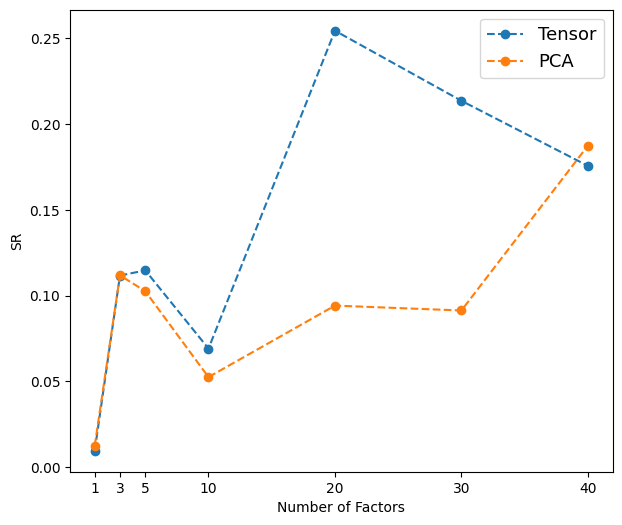

In [19]:
#ylim=[-0.1, 1.9]
filename = 'sr.pdf'

dict_fit_oos['Tensor'][1]['sr_oos'] = dict_fit_oos['Tensor'][1]['sr_oos'][0]

fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)

for method in ['Tensor','PCA']:
    ax.plot(lst_K, np.array([dict_fit_oos[method][K]['sr_oos'] for K in lst_K]),
            '--o',label=method)
ax.legend(fontsize=13);
ax.set_ylabel('SR')
ax.set_xlabel('Number of Factors')
ax.set_xticks(lst_K);
#ax.set_ylim(ylim)

fig.savefig(dir_out, bbox_inches='tight')

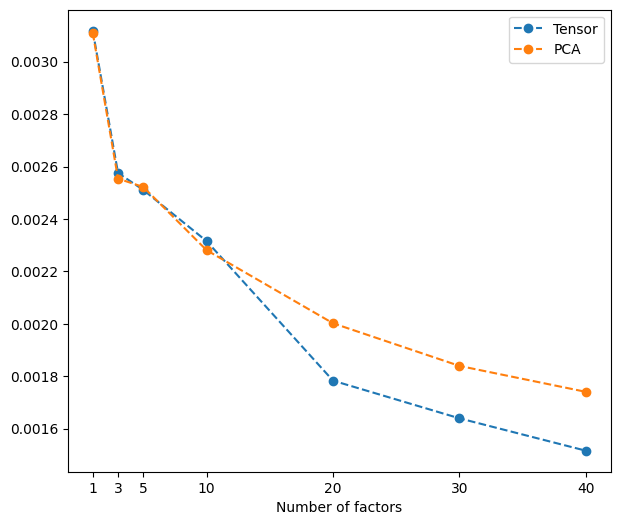

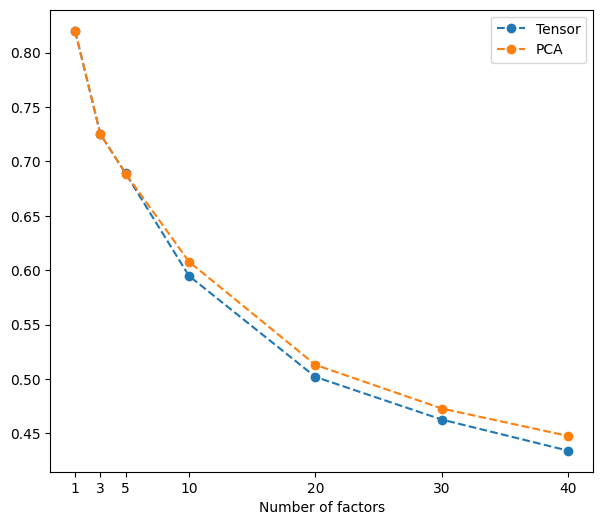

In [20]:
### xs-alpha and sigma_eps

for key in ['xs_alpha','sigma_eps']:

    fig=plt.figure(figsize=(7,6))
    ax=fig.add_subplot(1,1,1)
    for method in ['Tensor','PCA']:
        metric=np.real(collect_eval_metric(dict_fit_oos[method], lst_K, key))
        ax.plot(lst_K, metric,'--o',
                label=method)
    ax.set_xlabel('Number of factors');
    ax.legend();
    ax.set_xticks(lst_K);
    fig.savefig(dir_out+'{}.pdf'.format(key), bbox_inches='tight')

In [21]:
### plot term structure of alpha
lst_key = ['alpha','var_resid', 'eps_lag_rms']
filename = 'term_structure_{}_{}_K{}.pdf'
method='Tensor'


for method in ['Tensor', 'PCA']: 
    for key in lst_key:
        ylim = get_plot_ylim(dict_fit_oos[method], lst_K, key, q_lb=0.1)

        for K in lst_K:
            fig=plt.figure(figsize=(13,13))
            ax=fig.add_subplot(1,1,1)    
            sns.heatmap(dict_fit_oos[method][K]['eval'][key].T,
                        annot=False,
                        fmt='.0e',
                        ax=ax,
                        cmap=sns.color_palette("RdBu_r", n_colors=100),
                       vmin=ylim[0], vmax=ylim[1]);

            ax.set_yticks(np.arange(len(bin_labels)))
            ax.set_yticklabels(bin_labels ,rotation=0);

            ax.set_xticks(np.arange(0,max_lag,12))
            ax.set_xticklabels([str(i) for i in np.arange(1,max_lag+1,12)],rotation=0)
            ax.set_xlabel('Lags');

            fig.savefig(dir_out+filename.format(method, key, K), bbox_inches='tight')
            plt.close('all')

